<a href="https://colab.research.google.com/github/fkonrad97/Network/blob/main/routingtable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import csv
import pandas as pd
import numpy as np
import networkx as nx
import random
import math
from scipy.stats import entropy
import matplotlib.pyplot as plt
import statistics

# I/O

In [3]:
# Read positions of nodes (X,Y,Z)

def positionRead(name):
    positions = pd.read_csv(name + ".csv", header=None, sep=";")
    # Remove a plus ('+') sign from the end of the number
    # positions[0][0] = positions[0][0][:-1]
    positions[0] = positions[0].astype(float)    # Convert data to numerical value
    return positions

In [4]:
# Read connection table between nodes

def connectionRead(name):
    connections = pd.read_csv(name + ".csv", header=None)
    return connections

# Read datas in

In [5]:
# List of position tables
pos = []

# List of connection tables
conn = []

In [6]:
# List of the positions of nodes
pos.append(positionRead("/content/Brain11Positions"))

# List of how nodes connected to each other
conn.append(connectionRead("/content/Brain11Connections"))

In [7]:
pos.append(positionRead("/content/Brain12Positions"))
conn.append(connectionRead("/content/Brain12Connections"))

pos.append(positionRead("/content/Brain13Positions"))
conn.append(connectionRead("/content/Brain13Connections"))

pos.append(positionRead("/content/Brain14Positions"))
conn.append(connectionRead("/content/Brain14Connections"))

pos.append(positionRead("/content/Brain15Positions"))
conn.append(connectionRead("/content/Brain15Connections"))

pos.append(positionRead("/content/Brain16Positions"))
conn.append(connectionRead("/content/Brain16Connections"))

pos.append(positionRead("/content/Brain17Positions"))
conn.append(connectionRead("/content/Brain17Connections"))

pos.append(positionRead("/content/Brain18Positions"))
conn.append(connectionRead("/content/Brain18Connections"))

pos.append(positionRead("/content/Brain19Positions"))
conn.append(connectionRead("/content/Brain19Connections"))

pos.append(positionRead("/content/Brain110Positions"))
conn.append(connectionRead("/content/Brain110Connections"))

# Additional Methods

In [8]:
# Calculate distance between 2 points in Euclidean space
# Positions should be 3D (X,Y,Z) -> Dataset

def Euclidean_dist(p1, p2, positions):
    point1 = np.array((positions[0][p1], positions[1][p1], positions[2][p1]))
    point2 = np.array((positions[0][p2], positions[1][p2], positions[2][p2]))
    return np.linalg.norm(point1 - point2)

In [9]:
def Euclidean_dist2D(p1, p2):
    point1 = np.array((p1[0], p1[1]))
    point2 = np.array((p2[0], p2[1]))
    return np.linalg.norm(point1 - point2)

In [10]:
def hyperbolicDist(coord1, coord2):
  x1 = coord1[0]
  y1 = coord1[1]
  x2 = coord2[0]
  y2 = coord2[1]

  return np.arccosh(np.cosh(y1)*np.cosh(x2-x1)*np.cosh(y2)-np.sinh(y1)*np.sinh(y2))

In [11]:
# Add a key-value pair to the existing dictionary

def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

In [12]:
# Returns with a dictionary. Key is the number of the node and 
# the value is the distant between the current node(act) and its neighbour.
# The list is ascendant by the distance.

def get_dist(act, neighbours, positions):
    dist = {}
    
    for i in neighbours:
        add_element(dist, i, Euclidean_dist(act, i, positions))
    
    dist = sorted(dist.items(), key=lambda x: x[1])
    
    return dist

In [13]:
def chooseRandomShortest(paths):
  randomPaths = []

  for i in paths:
    randomPaths.append(random.choice(i))

  return randomPaths

In [14]:
def avgEntropy(graph, routingTables):
  sum = 0

  for i in range(len(graph.nodes)):
    routingTables[i].getNextHopsList()
    sum += entropy(routingTables[i].nextHops)
  
  return (sum / len(graph.nodes))

In [15]:
def readWeightedIn(connections, positions):
  greedyNeighbours = []
  for i in range(len(connections)):
    for j in range(len(connections)):
       if connections[i][j] == 1 and i < j:
          dist = Euclidean_dist(i,j,positions)
          greedyNeighbours.append([i,j,dist])
  return greedyNeighbours

In [16]:
def readUnweightedIn(connections):
  neighbours = []
  for i in range(len(connections)):
    for j in range(len(connections)):
      if connections[i][j] == 1 and i < j:
        neighbours.append([i, j])
  return neighbours

# Graph algorithms

In [17]:
def findPaths(src, graph):
  paths = []

  for j in range(len(graph.G.nodes)):
    if src!=j:
      path = [p for p in nx.all_shortest_paths(graph.G, source=src, target=j)]
      paths.append(path)
  
  return paths

In [18]:
def greedy(graph, src, dest):
  pathsGreedy = []
  pathsGreedy.append(src)
  ready = False
  act = src

  while ready==False:
    nbours = [n for n in graph.G.neighbors(act)]

    # Calculates the distances of the neighbour nodes from the end node
    dist = get_dist(dest, nbours, graph.positions)

    # if the 'dest' is connected with 'act'
    if dest in nbours:
      pathsGreedy.append(dest)
      return pathsGreedy

    # if 'act' has no neighbours 
    elif len(nbours) == 0:
      return "No neighbours"

    # if 'act' has just 1 neighbour
    elif len(nbours) == 1:
      act = nbours[0]
      pathsGreedy.append(act)

    elif len(nbours) > 1:
      not_found = False
      for i in dist:
        if i[0] not in pathsGreedy:
          act = i[0]
          pathsGreedy.append(act)
          not_found = True
          break
      # If there are no more choosable node on the list
      if not_found == False:
        act = dist[0][0]
        pathsGreedy.append(act)

# Network Generator

In [19]:
class Network:
    def __init__(self, inputRadius):
      self.inputRadius = inputRadius
      self.xCoordinate = []
      self.yCoordinate = []
      self.coordinates = []
      self.edges = []

    def add_edge(self, src, dest):
      edge = [src, dest]
      self.edges.append(edge)

    def growNetwork(self):
      for i in range(len(self.coordinates)):
        for j in range(len(self.coordinates)):
          if self.coordinates[i] != self.coordinates[j]:
            dist = hyperbolicDist(self.coordinates[i],self.coordinates[j])
            if dist < self.inputRadius:
              self.add_edge(i,j)

    def generatePoint(self):
      radius = self.inputRadius * math.sqrt(random.random())
      theta = 2 * math.pi * random.random()

      return radius * math.cos(theta), radius * math.sin(theta)

    def createNodes(self, n):
      self.xCoordinate, self.yCoordinate =  [], []
      for i in range(n):
          xc, yc = self.generatePoint()
          self.xCoordinate.append(xc)
          self.yCoordinate.append(yc)
      self.convertCoords(n)

    def convertCoords(self, n):
        for i in range(n):
           self.coordinates.append([self.xCoordinate[i], self.yCoordinate[i]])

    def plot(self):
        plt.figure(1)
        plt.plot(self.xCoordinate, self.yCoordinate,'b.')
        plt.grid('on')

        x_circle = [self.inputRadius*math.cos(i) for i in np.arange(0, math.pi*2, 0.01)]
        y_circle = [self.inputRadius*math.sin(i) for i in np.arange(0, math.pi*2, 0.01)]
        plt.plot(x_circle, y_circle, '-k')

# Classes

In [20]:
class Graph():
  def __init__(self):
    self.G = nx.Graph()
    self.nodes = self.G.nodes
    self.positions = []
    self.connections = []

  def addConnections(self, connections):
    self.connections = connections

  def addPositions(self, positions):
    self.positions = positions

  def addWeightedEdges(self):
    neighborList = readWeightedIn(self.connections, self.positions)
    for i in neighborList:
      self.G.add_edge(i[0], i[1], weight=i[2])

  def addWeightedNetworkEdges(self, network):
    for i in network.edges:
      self.G.add_edge(i[0], i[1], weight=Euclidean_dist2D(network.coordinates[i[0]],network.coordinates[i[1]]))

  def addUnweightedEdges(self):
    neighborList = readUnweightedIn(self.connections)
    for i in neighborList:
      self.G.add_edge(i[0],i[1])

In [21]:
class routingTable():

  def __init__(self, nodeID, graph):
    self.graph = graph
    self.nodeID = nodeID
    self.table = []
    self.nextHops = []

  def addtoTable(self, dest, nextHop):
    self.table.append([dest, nextHop])

  def findNextHop(self):
    paths = findPaths(self.nodeID, self.graph)
    paths = chooseRandomShortest(paths)
    for i in paths:
      self.addtoTable(i[-1], i[1])

  def findNextHopGreedy(self):
    paths = []
    for i in range(len(self.graph.nodes)):
      if self.nodeID!=i:
        paths.append(greedy(self.graph, self.nodeID, i))
    for i in paths:
      self.addtoTable(i[-1], i[1])

  def getNextHopsList(self):
    self.nextHops = []
    for i in self.table:
      self.nextHops.append(i[1])

# **GREEDY ALGORITHM**

In [22]:
def getGreedyEntropy(graph):
  Ggreedy = graph

  routingTablesGreedy = []

  for i in Ggreedy.nodes:
    table = routingTable(i, Ggreedy)
    table.findNextHopGreedy()
    routingTablesGreedy.append(table)

  entropyGreedyValue = avgEntropy(Ggreedy, routingTablesGreedy)
  return entropyGreedyValue

# **RANDOM UNWEIGHTED**

In [23]:
def getRandomEntropy(graph, iter):
  G = graph

  # Each nodes' routing table
  routingTables = []

  for j in range(iter):
    routingtable = []
    for i in range(len(G.nodes)):
      table = routingTable(i,G)
      table.findNextHop()
      routingtable.append(table)
    routingTables.append(routingtable)

  entropyList = []

  for i in routingTables:
    entropyList.append(avgEntropy(G, i))
    
  return statistics.mean(entropyList)

# **KRIUKOV GRÁFGENERÁLÁS**

In [24]:
# Generate network

def generateNetwork(radius, nodes):
  network = Network(radius)
  network.createNodes(nodes)
  network.growNetwork()
  return network

### **Random Kriukov**

In [25]:
def getKriukovGraphRandomEntropy(graph, iter):
  GKriukov = graph

  # Each nodes' routing table
  routingTablesKriukov = []

  for j in range(iter):
    routingtable = []
    for i in range(len(GKriukov.nodes)):
      table = routingTable(i,GKriukov)
      table.findNextHop()
      routingtable.append(table)
    routingTablesKriukov.append(routingtable)

  entropyListKriukov = []

  for i in routingTablesKriukov:
    entropyListKriukov.append(avgEntropy(GKriukov, i))

  return statistics.mean(entropyListKriukov)

## **Greedy Kriukov**

In [26]:
def getKriukovGraphGreedyEntropy(graph):
  GKriukov = graph

  routingTablesGreedyKriukov = []

  for i in GKriukov.nodes:
    table = routingTable(i, GKriukov)
    table.findNextHopGreedy()
    routingTablesGreedyKriukov.append(table)
  
  entropyGreedyKriukovValue = avgEntropy(GKriukov, routingTablesGreedyKriukov)
  return entropyGreedyKriukovValue

# Entropies

In [27]:
'''# Number of data tables
batchSize = len(pos)
# List of entropies:
# 1. Random algorithm entropies:
entropyRandom = []
# 2. Greedy algorithm entropies:
entropyGreedy = []
# 3. Random, Kriukov generated network entropies:
entropyRandomKriukov = []
# 4. Greedy, Kriukov generated network entropies:
entropyGreedyKriukov = []'''

In [28]:
'''for i in range(batchSize):
  # Network, routing tables and other methods use 'positions' and 'connections' list variable through the code. 
  # These two are the current data table during the iteration
  positions = pos[i]
  connections = conn[i]
  # How many nodes they include
  nodesNumber = len(positions[0])

  # Init Graph for random and greedy algorithms
  G = Graph()
  G.addConnections(connections)
  G.addPositions(positions)
  G.addUnweightedEdges()
  G.addWeightedEdges()

  # Create a network (radius = 1, nodes = nodesNumber)
  network = generateNetwork(1, nodesNumber)

  # Init Kriukov graph
  GKriukov = Graph()
  GKriukov.addConnections(connections)
  GKriukov.addPositions(positions)
  GKriukov.addWeightedNetworkEdges(network)

  # Random and Greedy entropies
  entropyRandom.append(getRandomEntropy(G, 10))
  entropyGreedy.append(getGreedyEntropy(G))

  # Random and Greedy on Kriukov networks
  entropyRandomKriukov.append(getKriukovGraphRandomEntropy(GKriukov, 10))
  entropyGreedyKriukov.append(getKriukovGraphGreedyEntropy(GKriukov))'''

0
1
2
3
4
5
6
7
8
9


<Figure size 1152x432 with 0 Axes>

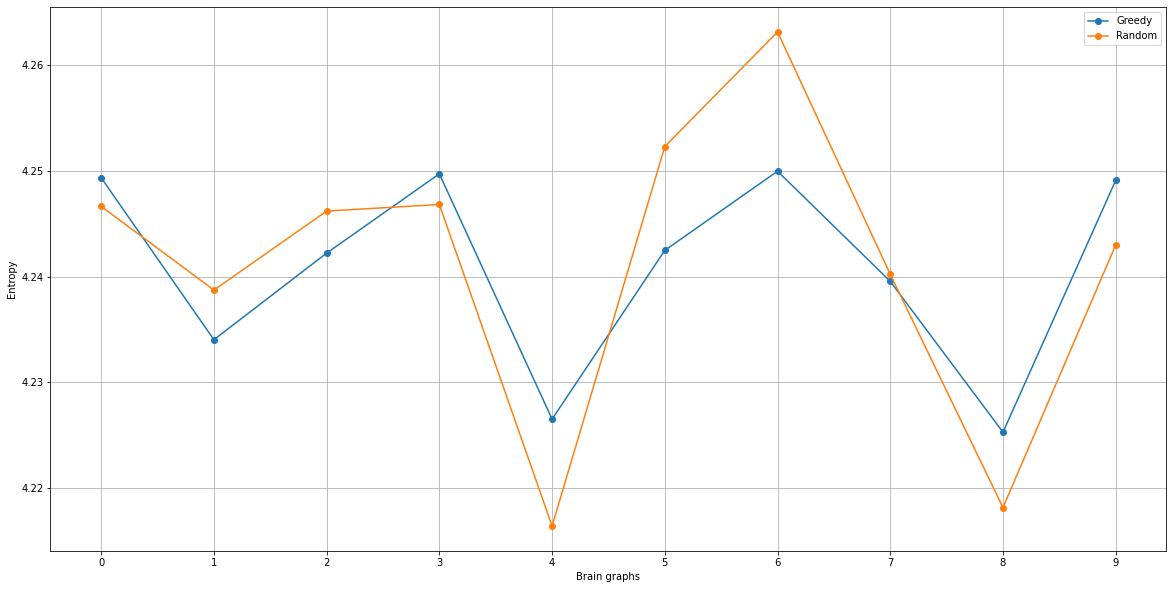

<Figure size 1152x432 with 0 Axes>

In [76]:
greedyPoints = np.array(entropyGreedy)
randomPoints = np.array(entropyRandom)

plt.plot(greedyPoints, marker = 'o', label="Greedy")
plt.plot(randomPoints, marker = 'o', label="Random")
plt.ylabel("Entropy")
plt.xlabel("Brain graphs")
plt.xticks(range(0,10))
plt.legend()
plt.grid()
plt.figure(figsize=(16, 6))

<Figure size 1152x432 with 0 Axes>

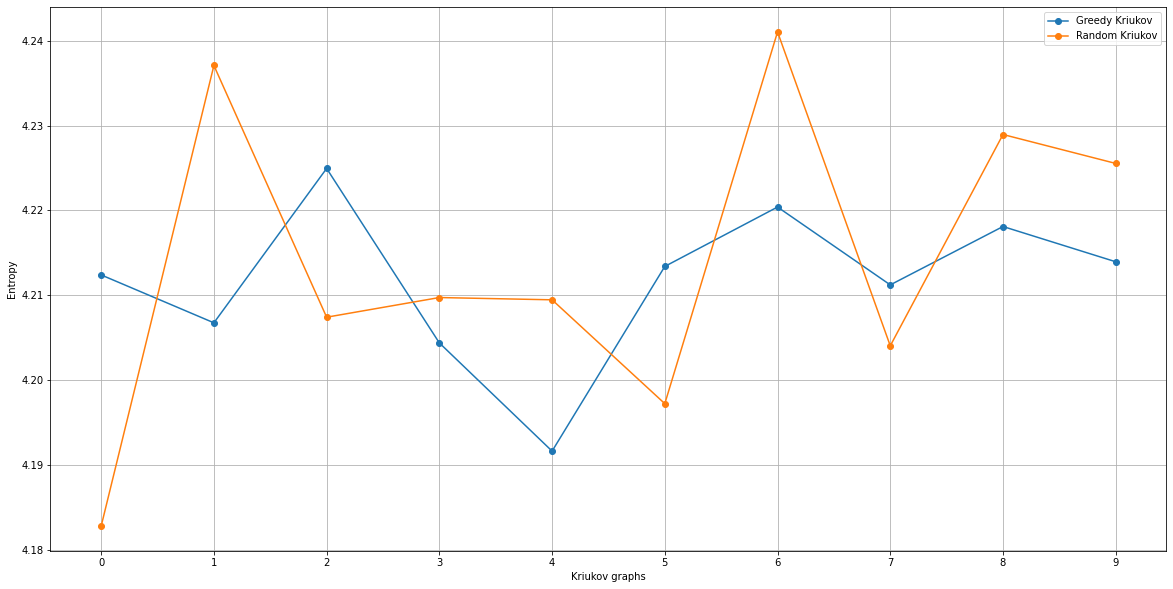

<Figure size 1152x432 with 0 Axes>

In [77]:
greedyKriukovpoints = np.array(entropyGreedyKriukov)
randomKriukovpoints = np.array(entropyRandomKriukov)

plt.plot(greedyKriukovpoints, marker = 'o', label="Greedy Kriukov")
plt.plot(randomKriukovpoints, marker = 'o', label="Random Kriukov")
plt.ylabel("Entropy")
plt.xlabel("Kriukov graphs")
plt.xticks(range(0,10))
plt.legend()
plt.grid()
plt.figure(figsize=(16, 6))